# Import Libraries

#### Modeling and Modeling Metrics Libraries 

In [81]:
# Models and Transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

# Model Metrics
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, f1_score, confusion_matrix
from sklearn import metrics

# Optimization
from sklearn.model_selection import GridSearchCV

#### (Auto)correlation

In [82]:
from pandas.plotting import autocorrelation_plot

#### Data Visualization

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### File Management

In [84]:
import os
import subprocess
import glob
import pickle

#### NLP & Text Parsing

In [85]:
import re
from textblob import TextBlob

In [86]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#### Pandas/NumPy/Datetime

In [87]:
import pandas as pd
import numpy as np

from datetime import datetime, date, time

#### Twitter/Stock Data Scraper

In [88]:
import snscrape.modules.twitter as sntwitter
import yfinance as yf

# Custom Functions

In [89]:
# Get Twitter Data (Saved as csv on local machine)

def scrapeTweets(start_date, end_date, keyword, current_dir, tweet_limit=1, iteration=0):
    if not os.path.exists(current_dir):  # Creates directory in current directory if doesn't already exist
        os.mkdir(current_dir)

    file_path = os.path.join(current_dir, f'keyword:{keyword}__start:{start_date}_end:{end_date}__iter:{iteration}.csv')

    tweet_list = []
    for i, tweet in enumerate(
            sntwitter.TwitterSearchScraper(f'{keyword} since:{start_date} until:{end_date}').get_items()):
        if i > tweet_limit:
            break
        tweet_list.append([tweet.date,  # Appending all tweet data into a list of list
                           tweet.id,
                           tweet.content,
                           tweet.user.username,
                           tweet.user.followersCount,
                           tweet.lang,
                           tweet.retweetCount,
                           tweet.likeCount,
                           tweet.replyCount])

    df_tweets = pd.DataFrame(tweet_list, columns=['Datetime',  # Creating df of tweet data
                                                  'Tweet Id',
                                                  'Text',
                                                  'Username',
                                                  'Followers Count',
                                                  'Language',
                                                  'Retweet Count',
                                                  'Likes Count',
                                                  'Reply Count'])

    for i in range(1001):
        if not os.path.isfile(file_path):
            df_tweets.to_csv(file_path, index=False)
            break
        else:
            file_path = os.path.join(current_dir,
                                     f'keyword:{keyword}__start:{start_date}_end:{end_date}__limit:{tweet_limit}__iter:{i + 1}.csv')

    if os.path.isfile(file_path):
        return print(f'Successfully saved DataFrame to {file_path}')
    return print('DataFrame not saved -- possible error has occurred.')

In [90]:
def dataWrangle_single(dataframe):   
    df_filter = dataframe[dataframe['Language'] == 'en'][['Datetime', # Filter via Language = 'en'
                                                           'Tweet Id', # Remove unwanted columns
                                                           'Text', 
                                                           'Username',
                                                           'Followers Count',
                                                           'Retweet Count',
                                                           'Likes Count',
                                                           'Reply Count']] 
    df_clean = df_filter.astype({'Tweet Id':str})\
                        .dropna()\
                        .drop_duplicates()\
                        .reset_index(drop=True)
    
    df_clean['Text'] = (df_clean['Text'] # Cleans out redundant string characters within each tweet
                       .apply(lambda x: ' '.join(re.sub(r'https\S+', '', x)
                                                .replace('\n', ' ')
                                                .split()
                                                )
                             )
                       )
    
    df_clean['Datetime'] = pd.to_datetime(df_clean['Datetime']).dt.floor('d').dt.tz_localize(tz=None)
    
    return df_clean.set_index('Datetime').sort_index()

In [91]:
# Wrangle Tweet Data

def dataWrangle_multiple(dataframe_list):   
    df_concat = pd.concat(dataframe_list) # Concatenate all the DataFrames from the list of DataFrames
    df_filter = df_concat[df_concat['Language'] == 'en'][['Datetime', # Filter via Language = 'en'
                                                           'Tweet Id', # Remove unwanted columns
                                                           'Text', 
                                                           'Username',
                                                           'Followers Count',
                                                           'Retweet Count',
                                                           'Likes Count',
                                                           'Reply Count']] 
    df_clean = df_filter.astype({'Tweet Id':str})\
                        .dropna()\
                        .drop_duplicates()\
                        .reset_index(drop=True)
    
    df_clean['Text'] = (df_clean['Text'] # Cleans out redundant string characters within each tweet
                       .apply(lambda x: ' '.join(re.sub(r'https\S+', '', x)
                                                .replace('\n', ' ')
                                                .split()
                                                )
                             )
                       )
    
    df_clean['Datetime'] = pd.to_datetime(df_clean['Datetime']).dt.floor('d').dt.tz_localize(tz=None)
    
    return df_clean.set_index('Datetime').sort_index()
                                               

In [92]:
# Get Stock Data (DataFrame)

def getStockData(ticker, start, end):
    df_stock = yf.download(ticker, start, end)
    df_stock.index = df_stock.index.tz_localize(tz=None).rename(name='Datetime')
    df_stock['Closing Differences'] = df_stock['Adj Close'].diff()
    df_stock['Percent Change'] = ((df_stock['Close']-df_stock['Open'])/df_stock['Open'])*100
    
    return df_stock    

In [93]:
# CLASSIFICATION Model Evaluation

def model_evaluation(model, X, y_true, positive_label):
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y_true, y_pred, pos_label=positive_label), 4)
    scores['recall'] = round(metrics.recall_score(y_true, y_pred, pos_label=positive_label), 4)
    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_true, probs, pos_label=positive_label)
    scores['area under precision-recall curve'] = round(metrics.auc(recalls, precisions), 4)
    scores['f1 score'] = round(f1_score(y_true=y_true, y_pred=y_pred, pos_label= "Positive_Trend"), 4)
    return scores

def print_model_evaluation(model_name, scores):
#     print('{} evaluation \n'.format(model_name))
    for metric, score in scores.items():
        print('Test {}: {}'.format(metric, score))


In [94]:
# 1. Polarity Score Categories as a column on DataFrame
# 2. Creating categorical polarity column

def polarityCategories_textblob(tup):
    if tup[0] < -0.05:
        return 'Negative'
    elif tup[0] > 0.05:
        return 'Positive'
    else:
        return 'Neutral'
    
def polarityColumns_textblob(df_tweets):
    df_tweets['Polarity/Subjectivity Scores'] = df_tweets['Text'].apply(lambda text: TextBlob(text).sentiment)
    df_tweets_filtered = df_tweets[df_tweets['Polarity/Subjectivity Scores'] != (0.0,0.0)]
    df_tweets_filtered = df_tweets_filtered.copy()
    df_tweets_filtered['Polarity Categories'] = df_tweets_filtered['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories(x))
    
    print(df_tweets_filtered.value_counts('Polarity Categories'))
    
    return df_tweets_filtered

In [95]:
def polarityCategories_vader(tup):
    if tup[0] < -0.05:
        return 'Negative'
    elif tup[0] > 0.05:
        return 'Positive'
    else:
        return 'Neutral'
    
def polarityColumns_vader(df_tweets):
    df_tweets['Sentiment'] = df_tweets['Text'].apply(lambda text: SentimentIntensityAnalyzer().polarity_scores(text))
#     df_tweets_filtered = df_tweets_filtered.copy()
#     df_tweets_filtered['Polarity Categories'] = df_tweets_filtered['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories_vader(x))
    
#     print(df_tweets_filtered.value_counts('Polarity Categories'))
    
    return df_tweets

In [96]:
def assign_score_columns(df):
    df['Positive Tweet Score'] = df['Sentiment'].apply(lambda scores: scores['pos'])
    df['Negative Tweet Score'] = df['Sentiment'].apply(lambda scores: scores['neg'])
    df['Neutral Tweet Score'] = df['Sentiment'].apply(lambda scores: scores['neu'])
    df['Compound Tweet Score'] = df['Sentiment'].apply(lambda scores: scores['compound'])
    
    df = df[df['Compound Tweet Score'] != 0.0]
    return df

# Twitter Data

## GME Tweets

In [ ]:
start_time = date(2021, 1, 8).strftime('%Y-%m-%d')
stop_time = date(2021, 2, 12).strftime('%Y-%m-%d')

In [13]:
# Creating a list of DataFrames using glob's list of files names
df_tweet_gme_list = []
for i in glob.glob('01-23_tweet/*'):
    df_tweet_gme_list.append(pd.read_csv(i))

In [16]:
df_tweet_GME = pd.read_csv('tweets_GME_01-01--06-30\\df_GME_incomplete.csv')

In [18]:
df_tweet_GME = dataWrangle_single(df_tweet_GME)

## Polarity Scores

### Saved wrangled df to pickle. Read pkl file to proceed

In [22]:
df_tweet_GME['Sentiment'] = df_tweet_GME['Text'].apply(lambda text: SentimentIntensityAnalyzer().polarity_scores(text))

In [29]:
df_tweet_GME = assign_score_columns(df_tweet_GME)

In [31]:
df_tweet_GME.to_pickle('df_tweet_GME_Vader.pkl')

In [17]:
df_tweet_GME = pd.read_pickle('C:/Users/Daanish/Desktop/capstone_project/project_environment/pickles/processed_data/df_tweet_GME_Vader.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/capstone_project/project_environment/pickles/processed_data/df_tweet_GME_Vader.pkl'

## Creating new features

In [56]:
df_tweet_GME['Compound Followers'] = df_tweet_GME['Followers Count'] * df_tweet_GME['Compound Tweet Score']

# Aggregation

In [57]:
df_tweet_GME_dailymean = df_tweet_GME.groupby('Datetime').mean().drop('Followers Count', axis=1)

In [58]:
pd.set_option("display.max_rows", 181)

In [59]:
df_tweet_GME_dailymean

,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Negative Tweet Score,Neutral Tweet Score,Compound Tweet Score,Compound Followers
Datetime,,,,,,,,
2021-01-01,0.949696,10.635733,1.125759,0.160056,0.062647,0.777298,0.269853,3.436436e+04
2021-01-02,68.192742,57.750000,3.098387,0.161263,0.052595,0.786141,0.327639,4.424941e+04
2021-01-03,1.685695,25.027535,2.658831,0.156467,0.064760,0.778779,0.273965,2.599319e+04
2021-01-04,1.246163,15.107438,2.065525,0.149979,0.058672,0.791347,0.258476,4.053196e+04
2021-01-05,0.873913,9.100870,0.984348,0.162212,0.057242,0.780561,0.313195,8.266200e+03
2021-01-06,1.461128,13.621958,1.153709,0.150668,0.094247,0.755075,0.175234,6.899461e+03
2021-01-07,2.293073,28.019982,6.027087,0.152779,0.085045,0.762185,0.209455,3.150429e+04
2021-01-08,0.722526,9.587767,1.551964,0.149320,0.072912,0.777754,0.244209,1.157453e+04
2021-01-09,0.254505,4.972973,1.345345,0.153336,0.077223,0.769426,0.241861,1.353479e+04


# Autocorrelation

(0.8, 20.0)

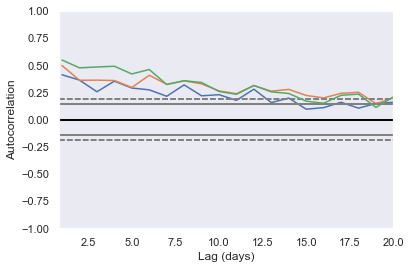

In [42]:
# Not the best plotting method

autocorrelation_plot(df_tweet_GME_dailymean['Positive Tweet Score'])
plt.xlabel('Lag (days)');
# plt.axvline(31, color = 'green')

autocorrelation_plot(df_tweet_GME_dailymean['Negative Tweet Score'])
plt.xlabel('Lag (days)');

autocorrelation_plot(df_tweet_GME_dailymean['Compound Tweet Score'])
plt.xlabel('Lag (days)');

plt.xlim([.8,20])

In [22]:
from statsmodels.tsa.stattools import acf


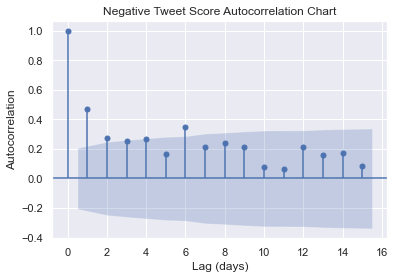

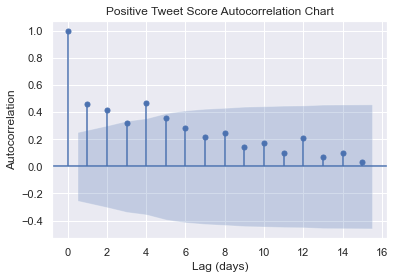

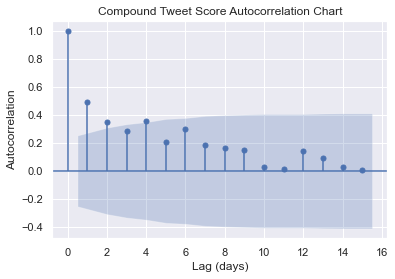

In [77]:
import statsmodels.api as sm

# STATISITCALLY SIGNIFICANT

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Negative Tweet Score'].loc[:'2021-3-31'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Negative Tweet Score Autocorrelation Chart');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Positive Tweet Score'].loc[:'2021-3-1'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Positive Tweet Score Autocorrelation Chart');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Compound Tweet Score'].loc[:'2021-3-1'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score Autocorrelation Chart');

In [ ]:
sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Negative Tweet Score'].loc[:'2021-4-30'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Negative Tweet Score Autocorrelation Chart');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Positive Tweet Score'].loc[:'2021-4-30'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Positive Tweet Score Autocorrelation Chart');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Compound Tweet Score'].loc[:'2021-4-30'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score Autocorrelation Chart');

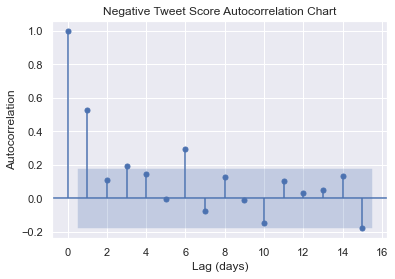

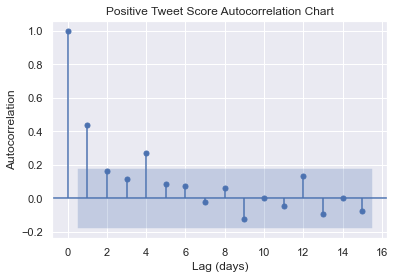

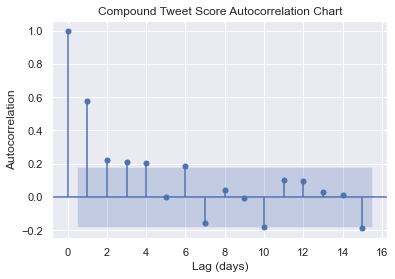

In [76]:
sm.graphics.tsa.plot_pacf(df_tweet_GME_dailymean['Negative Tweet Score'].loc[:'2021-4-30'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Negative Tweet Score Autocorrelation Chart');

sm.graphics.tsa.plot_pacf(df_tweet_GME_dailymean['Positive Tweet Score'].loc[:'2021-4-30'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Positive Tweet Score Autocorrelation Chart');

sm.graphics.tsa.plot_pacf(df_tweet_GME_dailymean['Compound Tweet Score'].loc[:'2021-4-30'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score Autocorrelation Chart');

In [60]:
df_tweet_GME_dailymean

,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Negative Tweet Score,Neutral Tweet Score,Compound Tweet Score,Compound Followers
Datetime,,,,,,,,
2021-01-01,0.949696,10.635733,1.125759,0.160056,0.062647,0.777298,0.269853,3.436436e+04
2021-01-02,68.192742,57.750000,3.098387,0.161263,0.052595,0.786141,0.327639,4.424941e+04
2021-01-03,1.685695,25.027535,2.658831,0.156467,0.064760,0.778779,0.273965,2.599319e+04
2021-01-04,1.246163,15.107438,2.065525,0.149979,0.058672,0.791347,0.258476,4.053196e+04
2021-01-05,0.873913,9.100870,0.984348,0.162212,0.057242,0.780561,0.313195,8.266200e+03
2021-01-06,1.461128,13.621958,1.153709,0.150668,0.094247,0.755075,0.175234,6.899461e+03
2021-01-07,2.293073,28.019982,6.027087,0.152779,0.085045,0.762185,0.209455,3.150429e+04
2021-01-08,0.722526,9.587767,1.551964,0.149320,0.072912,0.777754,0.244209,1.157453e+04
2021-01-09,0.254505,4.972973,1.345345,0.153336,0.077223,0.769426,0.241861,1.353479e+04


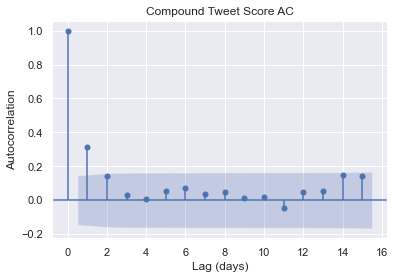

In [54]:
# MAYBE Statistically Significant

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Neutral Tweet Score'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score AC');

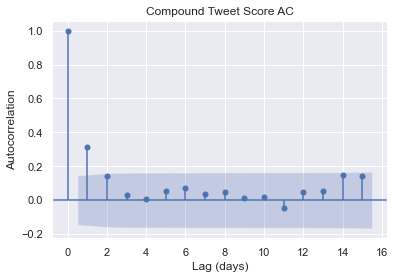

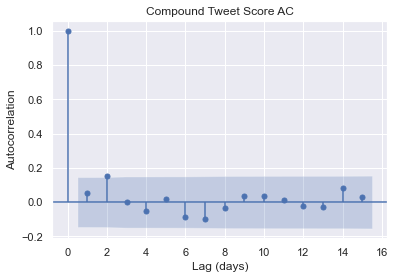

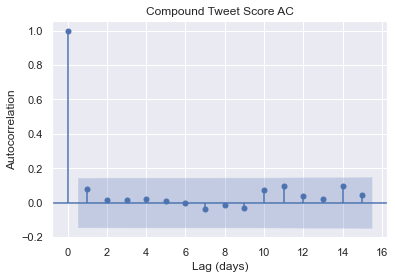

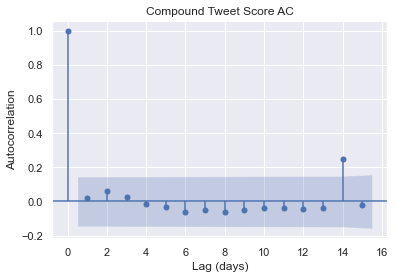

In [52]:
# Statistically INSIGNIFICANT

# sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Compound Followers'], lags=15, alpha=.05)
# plt.xlabel('Lag (days)')
# plt.ylabel('Autocorrelation')
# plt.title('Compound Tweet Score AC');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Reply Count'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score AC');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Likes Count'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score AC');

sm.graphics.tsa.plot_acf(df_tweet_GME_dailymean['Retweet Count'], lags=15, alpha=.05)
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Compound Tweet Score AC');

# Stock Data

## GME

In [106]:
df_stock_gme = getStockData('GME','2021-01-01','2021-06-30')

[*********************100%***********************]  1 of 1 completed


In [109]:
df_stock_gme

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,Percent Change
Datetime,,,,,,,,
2021-01-04,19.000000,19.100000,17.150000,17.250000,17.250000,10022500,NaN,-9.210526
2021-01-05,17.350000,18.080000,17.230000,17.370001,17.370001,4961500,0.120001,0.115276
2021-01-06,17.340000,18.980000,17.330000,18.360001,18.360001,6056200,0.990000,5.882356
2021-01-07,18.469999,19.450001,18.020000,18.080000,18.080000,6129300,-0.280001,-2.111529
2021-01-08,18.180000,18.299999,17.080000,17.690001,17.690001,6482000,-0.389999,-2.695268
2021-01-11,19.410000,20.650000,19.010000,19.940001,19.940001,14908000,2.250000,2.730555
2021-01-12,19.959999,20.400000,19.320000,19.950001,19.950001,7060700,0.010000,-0.050092
2021-01-13,20.420000,38.650002,20.030001,31.400000,31.400000,144501700,11.449999,53.770810
2021-01-14,38.090000,43.060001,33.049999,39.910000,39.910000,93717400,8.510000,4.778156


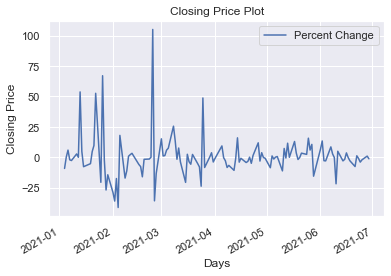

In [90]:
# Plot

df_stock_gme[['Percent Change']].plot()

# plt.ylim(-120, 120)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

## AAPL

In [89]:
df_stock_aapl = getStockData('AAPL', '2021-01-01', '2021-03-01')

[*********************100%***********************]  1 of 1 completed


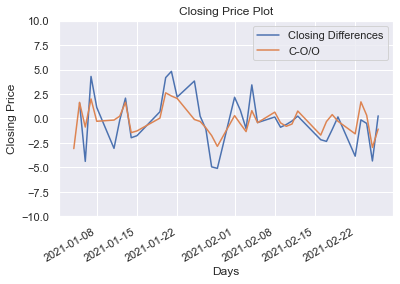

In [96]:
# Plot

df_stock_aapl[['Closing Differences', 'C-O/O']].plot()

plt.ylim(-10, 10)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

# Merging Twitter + Stock DataFrames

## GME

In [110]:
# Why is there NaN values for Volume and closing differences?
# Because the stock market is only opened on business days!
# So we dropped NaN values

df_merged_gme = df_stock_gme.merge(df_tweet_GME_dailymean, how='right', left_index=True, right_index=True)

In [115]:
df_merged_gme_nonull = df_merged_gme.dropna()

In [120]:
df_merged_gme_nonull['Percent Change Trend'] = df_merged_gme_nonull['Percent Change'].apply(lambda x: 'Negative_Trend' if x<0 else 'Positive_Trend')
df_merged_gme_nonull['Closing Differences Trend'] = df_merged_gme_nonull['Closing Differences'].apply(lambda x: 'Negative_Trend' if x<0 else 'Positive_Trend')

C:\Users\Daanish\AppData\Local\Temp/ipykernel_18968/4174700304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme_nonull['Percent Change Trend'] = df_merged_gme_nonull['Percent Change'].apply(lambda x: 'Negative_Trend' if x<0 else 'Positive_Trend')
C:\Users\Daanish\AppData\Local\Temp/ipykernel_18968/4174700304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme_nonull['Closing Differences Trend'] = df_merged_gme_nonull['Closing Differences'].apply(lambda x: 'Negative_Trend' if x

In [102]:
# df_merged_gme = df_merged_gme[['Volume', 'Closing Differences', 'Percent Change', 'Tweet Id', 'Followers Count', 'Retweet Count',
#                  'Likes Count', 'Reply Count', 'Positive Tweet Score', 'Neutral Tweet Score','Negative Tweet Score', 'Compound Tweet Score',
#                   'Compound Followers', 'Percent Change Trend', 'Closing Price Trend']]

KeyError: "['Tweet Id', 'Followers Count', 'Percent Change Trend', 'Closing Price Trend'] not in index"

In [105]:
# Interpolate NaN values (weekend values)
df_merged_gme[['Volume', 'Closing Differences', 'Percent Change']] = df_merged_gme[['Volume',
                                                                                    'Closing Differences',
                                                                                    'Percent Change']].interpolate(method='linear',
                                                                                                                   limit_direction='both',
                                                                                                                   axis=0)

In [115]:
df_merged_gme.to_pickle('df_merged_gme_jan2021-jun2021.pkl')

In [121]:
df_merged_gme_nonull.value_counts('Closing Differences Trend')

Closing Differences Trend
Negative_Trend    61
Positive_Trend    61
dtype: int64

In [111]:
# print(df_merged_gme.value_counts('Polarity Categories'))
df_merged_gme_nonull.value_counts('Percent Change Trend')

Percent Change Trend
Negative_Trend    68
Positive_Trend    54
dtype: int64

In [161]:
df_merged_gme_nonull.value_counts('CPT Label 3days ahead')

CPT Label 3days ahead
Negative_Trend    60
Positive_Trend    59
dtype: int64

In [124]:
df_merged_gme_nonull=df_merged_gme_nonull.dropna()

In [122]:
df_merged_gme_nonull['PCT Label 3days ahead'] = df_merged_gme_nonull['Percent Change Trend'].shift(-3)
df_merged_gme_nonull['CPT Label 3days ahead'] = df_merged_gme_nonull['Closing Differences Trend'].shift(-3)

C:\Users\Daanish\AppData\Local\Temp/ipykernel_18968/1224617130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme_nonull['PCT Label 3days ahead'] = df_merged_gme_nonull['Percent Change Trend'].shift(-3)
C:\Users\Daanish\AppData\Local\Temp/ipykernel_18968/1224617130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_gme_nonull['CPT Label 3days ahead'] = df_merged_gme_nonull['Closing Differences Trend'].shift(-3)


In [125]:
df_merged_gme_nonull

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,Percent Change,Retweet Count,Likes Count,Reply Count,Positive Tweet Score,Negative Tweet Score,Neutral Tweet Score,Compound Tweet Score,Compound Followers,Percent Change Trend,Closing Differences Trend,PCT Label 3days ahead,CPT Label 3days ahead
Datetime,,,,,,,,,,,,,,,,,,,,
2021-01-05,17.350000,18.080000,17.230000,17.370001,17.370001,4961500.0,0.120001,0.115276,0.873913,9.100870,0.984348,0.162212,0.057242,0.780561,0.313195,8.266200e+03,Positive_Trend,Positive_Trend,Negative_Trend,Negative_Trend
2021-01-06,17.340000,18.980000,17.330000,18.360001,18.360001,6056200.0,0.990000,5.882356,1.461128,13.621958,1.153709,0.150668,0.094247,0.755075,0.175234,6.899461e+03,Positive_Trend,Positive_Trend,Positive_Trend,Positive_Trend
2021-01-07,18.469999,19.450001,18.020000,18.080000,18.080000,6129300.0,-0.280001,-2.111529,2.293073,28.019982,6.027087,0.152779,0.085045,0.762185,0.209455,3.150429e+04,Negative_Trend,Negative_Trend,Negative_Trend,Positive_Trend
2021-01-08,18.180000,18.299999,17.080000,17.690001,17.690001,6482000.0,-0.389999,-2.695268,0.722526,9.587767,1.551964,0.149320,0.072912,0.777754,0.244209,1.157453e+04,Negative_Trend,Negative_Trend,Positive_Trend,Positive_Trend
2021-01-11,19.410000,20.650000,19.010000,19.940001,19.940001,14908000.0,2.250000,2.730555,1.638151,16.191740,1.411996,0.146120,0.075187,0.778701,0.201303,4.987613e+04,Positive_Trend,Positive_Trend,Positive_Trend,Positive_Trend
2021-01-12,19.959999,20.400000,19.320000,19.950001,19.950001,7060700.0,0.010000,-0.050092,1.562269,12.274969,1.416769,0.147534,0.078565,0.773874,0.216202,2.449617e+04,Negative_Trend,Positive_Trend,Negative_Trend,Negative_Trend
2021-01-13,20.420000,38.650002,20.030001,31.400000,31.400000,144501700.0,11.449999,53.770810,1.394794,15.853218,2.199566,0.154312,0.081010,0.764671,0.235850,1.230981e+04,Positive_Trend,Positive_Trend,Negative_Trend,Positive_Trend
2021-01-14,38.090000,43.060001,33.049999,39.910000,39.910000,93717400.0,8.510000,4.778156,2.476476,22.224224,1.989489,0.157344,0.071119,0.771539,0.252038,8.528880e+04,Positive_Trend,Positive_Trend,Positive_Trend,Negative_Trend
2021-01-15,38.490002,40.750000,34.009998,35.500000,35.500000,46866400.0,-4.410000,-7.768256,3.382286,27.761544,1.897048,0.161478,0.074416,0.764107,0.242620,6.343947e+04,Negative_Trend,Negative_Trend,Positive_Trend,Positive_Trend


## AAPL

# Dealing with Imbalances

In [34]:
from imblearn.over_sampling import SMOTE

In [35]:
sampler = SMOTE(random_state=42)

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X_train, y_train)

# Modeling

## GME

#### Train/Test Split

In [148]:
X = df_merged_gme_nonull
y = df_merged_gme_nonull['CPT Label 3days ahead']

In [199]:
relevant_columns = ['Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers', 'Volume']

In [228]:
X_train = X[relevant_columns].loc[:'2021-5-23']
X_test  = X[relevant_columns].loc['2021-5-24':]

y_train = y.loc[:'2021-5-23']
y_test = y.loc['2021-5-24':]

In [207]:
# X_train.to_pickle('X_1-1--5-21_TRAIN.pkl')
# X_test.to_pickle('X_5-24--6-24_NEW.pkl')
# y_train.to_pickle('y_1-1--5-21_TRAIN_CPT-3.pkl')
# y_test.to_pickle('y_5-24--6-24_NEW_CPT-3.pkl')

#### Support Vector Machine (Baseline)

In [380]:
transformer_svm = ColumnTransformer([
    ('scaler', StandardScaler(), ['Followers Count', 'Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers'])
])

In [381]:
pipe_svm = Pipeline([
    ('ohe', transformer_svm),
    ('svm', svm.SVC(kernel='poly'))
])

In [384]:
pipe_svm_fit = pipe_svm.fit(X[['Followers Count', 'Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers']].loc[:'2021-4-3'], y)

In [385]:
pipe_svm_fit.score(X_testo, y_testo)

0.6129032258064516

In [378]:
pipe_svm_fit.classes_

array(['Negative_Trend', 'Positive_Trend'], dtype=object)

In [379]:
pipe_svm_fit.feature_names_in_

array(['Followers Count', 'Retweet Count', 'Likes Count', 'Reply Count',
       'Positive Tweet Score', 'Negative Tweet Score',
       'Neutral Tweet Score', 'Compound Followers', 'Volume'],
      dtype=object)

#### Random Forest Classifier (Baseline)

In [202]:
X_train.columns

Index(['Retweet Count', 'Likes Count', 'Reply Count', 'Positive Tweet Score',
       'Negative Tweet Score', 'Neutral Tweet Score', 'Compound Followers',
       'Volume'],
      dtype='object')

In [229]:
transformer_rfc = ColumnTransformer([
    ('scaler', StandardScaler(), ['Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers', 'Volume'])
    
])

In [309]:
pipe_rfc = Pipeline([
    ('ohe scaler', transformer_rfc),
    ('randomforest', RandomForestClassifier(n_estimators=500, random_state=42))
])

In [310]:
pipe_rfc_fit = pipe_rfc.fit(X_train, y_train)

In [294]:
pipe = pickle.load(open('pipe_rfc_fit_jan-may_PCT3daylag.pkl', 'rb'))

In [297]:
pickle.dump(pipe_rfc_fit, open('pipe_rfc_fit_jan-may_PCT3daylag.pkl', 'wb'))

In [311]:
model_evaluation(pipe_rfc_fit, X_test, y_test, positive_label='Positive_Trend')

{'accuracy': 0.6957,
 'precision': 0.6429,
 'recall': 0.8182,
 'area under precision-recall curve': 0.6692,
 'f1 score': 0.72}

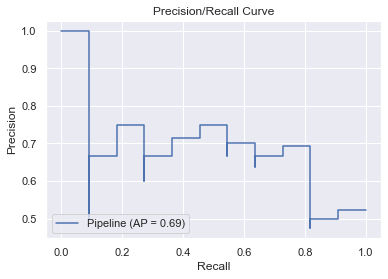

In [312]:
# 3 day shift on labels

PrecisionRecallDisplay.from_estimator(pipe_rfc_fit, X_test, y_test)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve');

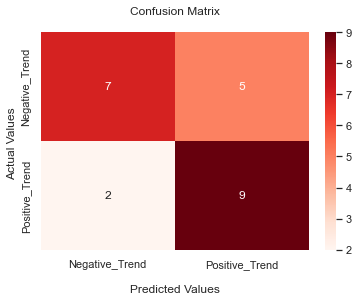

In [321]:
ax = sns.heatmap(cf, annot=True, cmap='Reds')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative_Trend','Positive_Trend'])
ax.yaxis.set_ticklabels(['Negative_Trend','Positive_Trend'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [314]:
# 3 day shift on labels

cf = confusion_matrix(y_true=y_test, y_pred=pipe_rfc_fit.predict(X_test))

In [144]:
# no shift on labels -- TEST
confusion_matrix(y_true=y_test, y_pred=pipe_rfc_fit.predict(X_test), labels=pipe_rfc_fit.classes_)

array([[8, 2],
       [8, 5]], dtype=int64)

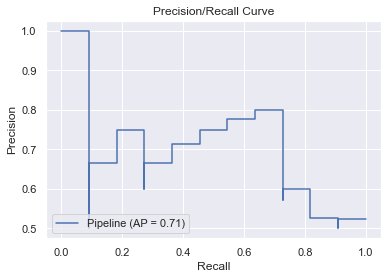

In [224]:
# no shift on labels -- TEST
PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve');

#### Logistic Regression (Baseline)

In [220]:
transformer_logit = ColumnTransformer([
    ('scaler', StandardScaler(), ['Retweet Count', 'Likes Count', 'Reply Count',
                                  'Positive Tweet Score', 'Negative Tweet Score', 'Neutral Tweet Score',
                                  'Compound Followers', 'Volume'])
])

In [221]:
pipe_logit = Pipeline([
    ('ohe', transformer_logit),
    ('logit', LogisticRegression())
])

In [222]:
pipe_logit_fit = pipe_logit.fit(X_train, y_train)

In [223]:
model_evaluation(pipe_logit, X_test, y_test, positive_label='Positive_Trend')

{'accuracy': 0.3913,
 'precision': 0.3636,
 'recall': 0.3636,
 'area under precision-recall curve': 0.4379,
 'f1 score': 0.3636}

In [345]:
pipe_logit_fit.predict_proba(X_test)

array([[0.38150739, 0.61849261],
       [0.84071646, 0.15928354],
       [0.47308669, 0.52691331],
       [0.59166055, 0.40833945],
       [0.4394202 , 0.5605798 ],
       [0.90766538, 0.09233462],
       [0.38408909, 0.61591091],
       [0.58019247, 0.41980753],
       [0.57084401, 0.42915599],
       [0.51744713, 0.48255287],
       [0.70100076, 0.29899924],
       [0.84054068, 0.15945932],
       [0.54794139, 0.45205861],
       [0.52383588, 0.47616412],
       [0.54014473, 0.45985527],
       [0.39809021, 0.60190979],
       [0.16523788, 0.83476212],
       [0.83071609, 0.16928391]])